# Extra Credit for Peer Discussion 2
## Competitor Analysis: Microsoft, Google, Amazon, Apple
### Daniel Fox

Note: The bulk of this code was written using claude.ai (after **many** failed iterations by the AI)

#### Step 1: Load Packages

Note: you may need to install some of these libraries using pip install

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

#### Step 2: Extract data from yahoo finance
We do this using the yfinance (yahoo finance) package. We'll get some data on share price, P-E ratio, etc.

In [2]:
def get_company_data(ticker):
    """
    Fetch real financial data from Yahoo Finance using yfinance
    """
    print(f"Fetching {ticker} data from Yahoo Finance...")
    
    # Create ticker object
    company = yf.Ticker(ticker)
    
    # Get various data
    data = {}
    data['ticker'] = ticker
    
    try:
        # Get current stock info
        info = company.info
        data['company_name'] = info.get('longName', ticker)
        data['current_price'] = info.get('currentPrice', info.get('regularMarketPrice', 0))
        data['market_cap'] = info.get('marketCap', 0)
        data['shares_outstanding'] = info.get('sharesOutstanding', 0)
        data['trailing_pe'] = info.get('trailingPE', 0)
        data['forward_pe'] = info.get('forwardPE', 0)
        
        # Get quarterly financials
        quarterly_financials = company.quarterly_financials
        data['quarterly_financials'] = quarterly_financials
        
        # Get annual financials
        annual_financials = company.financials
        data['annual_financials'] = annual_financials
        
        # Get quarterly income statement (more detailed)
        quarterly_income_stmt = company.quarterly_income_stmt
        data['quarterly_income'] = quarterly_income_stmt
        
        # Get annual income statement
        annual_income_stmt = company.income_stmt
        data['annual_income'] = annual_income_stmt
        
        print(f"✓ Successfully fetched {ticker} financial data")
        return data
        
    except Exception as e:
        print(f"Error fetching {ticker} data: {e}")
        return None


#### Step 3: Extract quartely revenue from the data

In [3]:
def extract_quarterly_revenue(quarterly_income, ticker):
    """
    Extract quarterly revenue from the fetched data
    """
    try:
        if quarterly_income is not None and not quarterly_income.empty:
            # Get Total Revenue row
            if 'Total Revenue' in quarterly_income.index:
                revenue_row = quarterly_income.loc['Total Revenue']
            elif 'Total revenue' in quarterly_income.index:
                revenue_row = quarterly_income.loc['Total revenue']
            else:
                # Try to find revenue in different possible names
                revenue_indices = [idx for idx in quarterly_income.index if 'revenue' in idx.lower()]
                if revenue_indices:
                    revenue_row = quarterly_income.loc[revenue_indices[0]]
                else:
                    print(f"Could not find revenue data for {ticker}")
                    return None
            
            # Convert to billions and create dictionary with actual dates
            revenue_data = {}
            for date, value in revenue_row.items():
                if pd.notna(value):
                    revenue_data[date] = value / 1e9  # Convert to billions
            
            # Sort by date (chronological order)
            sorted_revenue = dict(sorted(revenue_data.items(), key=lambda x: x[0]))
            
            # Get last 8 quarters for cleaner comparison
            recent_quarters = dict(list(sorted_revenue.items())[-8:])
            
            return recent_quarters
    except Exception as e:
        print(f"Error extracting quarterly revenue for {ticker}: {e}")
        return None

#### Step 4: Create quarter labels for our graph

This step was the hardest thing for the AI to do. It took many attempts for it to finally solve the issue.

In [4]:
def create_quarter_labels(dates):
    """
    Create clean quarter labels from datetime objects
    """
    quarter_labels = []
    for date_obj in dates:
        try:
            if hasattr(date_obj, 'year') and hasattr(date_obj, 'month'):
                year = date_obj.year
                month = date_obj.month
                quarter = (month - 1) // 3 + 1
                quarter_labels.append(f"{year}-Q{quarter}")
            else:
                quarter_labels.append(str(date_obj)[:10])
        except Exception as e:
            quarter_labels.append(str(date_obj)[:10])
    
    return quarter_labels

#### Step 5: Create quarterly revenue comparison graph
Here, we define a function that plots a time series comparing revenue across our various companies

In [5]:
def plot_comparative_revenue(companies_data):
    """
    Plot quarterly revenue comparison for all companies
    """
    plt.figure(figsize=(16, 10))
    
    colors = ['#ff9500', '#4285f4', '#00ac47', '#007aff']  # Amazon orange, Google blue, Microsoft green, Apple blue
    company_names = ['Microsoft', 'Google', 'Amazon', 'Apple']
    
    all_quarter_labels = None
    
    for i, (ticker, data) in enumerate(companies_data.items()):
        if data is None:
            continue
            
        quarterly_revenue = extract_quarterly_revenue(data['quarterly_income'], ticker)
        if not quarterly_revenue:
            continue
            
        # Extract dates and revenues
        dates = list(quarterly_revenue.keys())
        revenues = list(quarterly_revenue.values())
        
        # Sort by date
        combined = list(zip(dates, revenues))
        combined.sort(key=lambda x: x[0])
        dates, revenues = zip(*combined)
        
        # Create quarter labels (use the same for all companies)
        if all_quarter_labels is None:
            all_quarter_labels = create_quarter_labels(dates)
        
        # Plot line for this company
        x_pos = range(len(revenues))
        plt.plot(x_pos, revenues, marker='o', linewidth=3, markersize=8,
                color=colors[i], label=f'{company_names[i]} ({ticker})',
                markerfacecolor='white', markeredgecolor=colors[i], markeredgewidth=2)
    
    # Format plot
    plt.title('Big Tech Quarterly Revenue Comparison - Last 8 Quarters (MSFT, GOOGL, AMZN, AAPL)', 
              fontsize=18, fontweight='bold', pad=20)
    plt.xlabel('Quarter', fontsize=14)
    plt.ylabel('Revenue (Billions USD)', fontsize=14)
    
    if all_quarter_labels:
        plt.xticks(range(len(all_quarter_labels)), all_quarter_labels, rotation=45, ha='right')
    
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.legend(fontsize=12, loc='upper left')
    plt.tight_layout()
    plt.show()

#### Step 6: 2x2 plot of revenue growth
With this function, we'll basically split our previous graph into a 2x2 grid to show the individual revenue growth for each company. We'll also plot the average revenue growth for each respective company.

In [6]:
def plot_individual_company_charts(companies_data):
    """
    Create individual time series charts for each company
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Individual Company Quarterly Revenue Analysis', fontsize=16, fontweight='bold')
    
    colors = ['#ff9500', '#4285f4', '#00ac47', '#007aff']
    company_names = ['Microsoft', 'Google', 'Amazon', 'Apple']
    
    plot_idx = 0
    
    for i, (ticker, data) in enumerate(companies_data.items()):
        if data is None or plot_idx >= 4:
            continue
            
        row = plot_idx // 2
        col = plot_idx % 2
        ax = axes[row, col]
        
        quarterly_revenue = extract_quarterly_revenue(data['quarterly_income'], ticker)
        if not quarterly_revenue:
            continue
            
        # Extract and sort data
        dates = list(quarterly_revenue.keys())
        revenues = list(quarterly_revenue.values())
        combined = list(zip(dates, revenues))
        combined.sort(key=lambda x: x[0])
        dates, revenues = zip(*combined)
        
        quarter_labels = create_quarter_labels(dates)
        x_pos = range(len(revenues))
        
        # Plot for this company
        ax.plot(x_pos, revenues, marker='o', linewidth=3, markersize=6,
               color=colors[i], markerfacecolor='white', 
               markeredgecolor=colors[i], markeredgewidth=2)
        
        # Add value labels
        for j, revenue in enumerate(revenues):
            ax.annotate(f'${revenue:.1f}B', (j, revenue),
                       textcoords="offset points", xytext=(0,8), ha='center',
                       fontsize=8, fontweight='bold',
                       bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.8))
        
        # Calculate QoQ growth and add trend line
        qoq_growth = []
        for j in range(1, len(revenues)):
            growth = ((revenues[j] - revenues[j-1]) / revenues[j-1]) * 100
            qoq_growth.append(growth)
        
        if qoq_growth:
            avg_growth = np.mean(qoq_growth)
            z = np.polyfit(x_pos, revenues, 1)
            p = np.poly1d(z)
            ax.plot(x_pos, p(x_pos), "--", alpha=0.7, color='red',
                   linewidth=2, label=f'Avg QoQ: {avg_growth:.1f}%')
            ax.legend(fontsize=10)
        
        # Format subplot
        ax.set_title(f'{company_names[i]} ({ticker})', fontsize=14, fontweight='bold')
        ax.set_xlabel('Quarter', fontsize=12)
        ax.set_ylabel('Revenue (Billions USD)', fontsize=12)
        ax.set_xticks(x_pos)
        ax.set_xticklabels(quarter_labels, rotation=45, ha='right')
        ax.grid(True, alpha=0.3, linestyle='--')
        
        plot_idx += 1
    
    plt.tight_layout()
    plt.show()


#### Step 7: Calculate net profit margin

In [7]:
def calculate_net_profit_margin(annual_income):
    """
    Calculate net profit margin from real data
    """
    try:
        if annual_income is not None and not annual_income.empty:
            latest_year = annual_income.columns[0]
            
            # Find total revenue
            revenue_keys = [key for key in annual_income.index if 'total revenue' in key.lower()]
            if revenue_keys:
                total_revenue = annual_income.loc[revenue_keys[0], latest_year]
            else:
                return None
            
            # Find net income
            net_income_keys = [key for key in annual_income.index if 'net income' in key.lower()]
            if net_income_keys:
                net_income = annual_income.loc[net_income_keys[0], latest_year]
            else:
                return None
            
            if pd.notna(total_revenue) and pd.notna(net_income) and total_revenue != 0:
                net_profit_margin = (net_income / total_revenue) * 100
                return net_profit_margin, total_revenue, net_income
            
    except Exception as e:
        print(f"Error calculating net profit margin: {e}")
    
    return None

#### Step 8: Create comparison table
This function compares each company with respect to the financial indicators we've selected, and puts it into a nice table

In [8]:
def create_comparison_table(companies_data):
    """
    Create a comprehensive comparison table
    """
    print("\n" + "=" * 100)
    print("BIG TECH FINANCIAL COMPARISON - REAL-TIME DATA")
    print("=" * 100)
    
    # Headers
    print(f"{'Company':<15} {'Ticker':<8} {'Price':<12} {'Market Cap':<15} {'P/E Ratio':<12} {'Profit Margin':<15}")
    print("-" * 100)
    
    for ticker, data in companies_data.items():
        if data is None:
            continue
            
        # Format market cap
        market_cap_formatted = f"${data['market_cap']/1e12:.2f}T" if data['market_cap'] > 1e12 else f"${data['market_cap']/1e9:.1f}B"
        
        # Get profit margin
        margin_data = calculate_net_profit_margin(data['annual_income'])
        margin_str = f"{margin_data[0]:.1f}%" if margin_data else "N/A"
        
        # Format P/E ratio
        pe_str = f"{data['trailing_pe']:.1f}" if data['trailing_pe'] and data['trailing_pe'] > 0 else "N/A"
        
        print(f"{data['company_name'][:14]:<15} {ticker:<8} ${data['current_price']:<11.2f} {market_cap_formatted:<15} {pe_str:<12} {margin_str:<15}")
    
    print("=" * 100)

#### Step 9: Growth analysis
This function will analyze the percent change in quarterly growth, as well as the average growth, for each company.

In [9]:
def analyze_growth_trends(companies_data):
    """
    Analyze and compare growth trends
    """
    print("\n" + "=" * 80)
    print("QUARTERLY GROWTH ANALYSIS")
    print("=" * 80)
    
    for ticker, data in companies_data.items():
        if data is None:
            continue
            
        quarterly_revenue = extract_quarterly_revenue(data['quarterly_income'], ticker)
        if not quarterly_revenue:
            continue
            
        dates = list(quarterly_revenue.keys())
        revenues = list(quarterly_revenue.values())
        combined = list(zip(dates, revenues))
        combined.sort(key=lambda x: x[0])
        dates, revenues = zip(*combined)
        
        quarter_labels = create_quarter_labels(dates)
        
        # Calculate QoQ growth
        qoq_growth = []
        for i in range(1, len(revenues)):
            growth = ((revenues[i] - revenues[i-1]) / revenues[i-1]) * 100
            qoq_growth.append(growth)
        
        print(f"\n{data['company_name']} ({ticker}) - Quarter-over-Quarter Growth:")
        print("-" * 60)
        for i, growth in enumerate(qoq_growth):
            if i + 1 < len(quarter_labels):
                print(f"{quarter_labels[i + 1]}: {growth:+.1f}%")
        
        if qoq_growth:
            avg_growth = np.mean(qoq_growth)
            print(f"Average QoQ Growth: {avg_growth:+.1f}%")

#### Step 10: Define main function
This function puts it all together!

In [10]:
def main():
    """
    Main function to execute the multi-company financial analysis
    """
    print("Big Tech Financial Analysis - Microsoft, Google, Amazon, Apple")
    print("=" * 65)
    
    # Define companies to analyze
    tickers = ['MSFT', 'GOOGL', 'AMZN', 'AAPL']
    companies_data = {}
    
    # Fetch data for all companies
    for ticker in tickers:
        companies_data[ticker] = get_company_data(ticker)
    
    # Filter out failed data fetches
    companies_data = {k: v for k, v in companies_data.items() if v is not None}
    
    if companies_data:
        # Create comparison table
        create_comparison_table(companies_data)
        
        # Create comparative revenue chart
        print("\nGenerating comparative revenue chart...")
        plot_comparative_revenue(companies_data)
        
        # Create individual company charts
        print("\nGenerating individual company charts...")
        plot_individual_company_charts(companies_data)
        
        # Analyze growth trends
        analyze_growth_trends(companies_data)
        
        print(f"\n📊 Analysis completed for {len(companies_data)} companies")
        
    else:
        print("❌ Failed to fetch data for any companies")
        print("Please check your internet connection and try again")


#### Step 11: Run the main function
Now it's time to see the results!

Big Tech Financial Analysis - Microsoft, Google, Amazon, Apple
Fetching MSFT data from Yahoo Finance...
✓ Successfully fetched MSFT financial data
Fetching GOOGL data from Yahoo Finance...
✓ Successfully fetched GOOGL financial data
Fetching AMZN data from Yahoo Finance...
✓ Successfully fetched AMZN financial data
Fetching AAPL data from Yahoo Finance...
✓ Successfully fetched AAPL financial data

BIG TECH FINANCIAL COMPARISON - REAL-TIME DATA
Company         Ticker   Price        Market Cap      P/E Ratio    Profit Margin  
----------------------------------------------------------------------------------------------------
Microsoft Corp  MSFT     $508.45      $3.78T          37.3         36.1%          
Alphabet Inc.   GOOGL    $252.03      $3.05T          26.9         28.6%          
Amazon.com, In  AMZN     $231.23      $2.47T          35.2         9.3%           
Apple Inc.      AAPL     $237.88      $3.53T          36.1         24.0%          

Generating comparative revenue cha

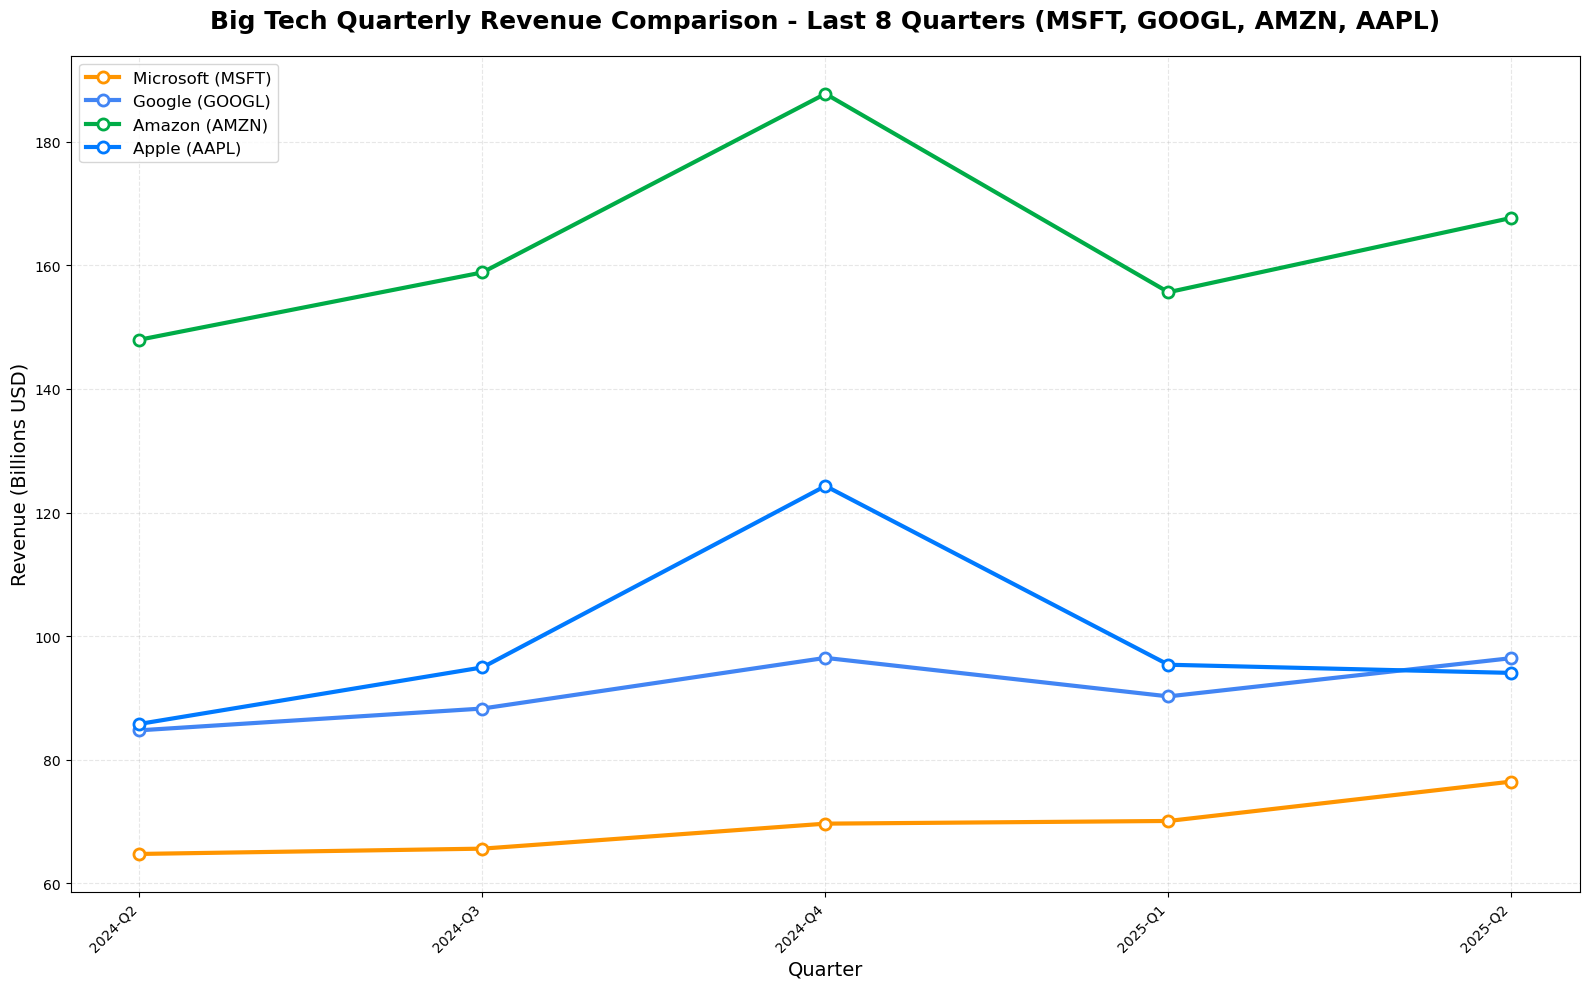


Generating individual company charts...


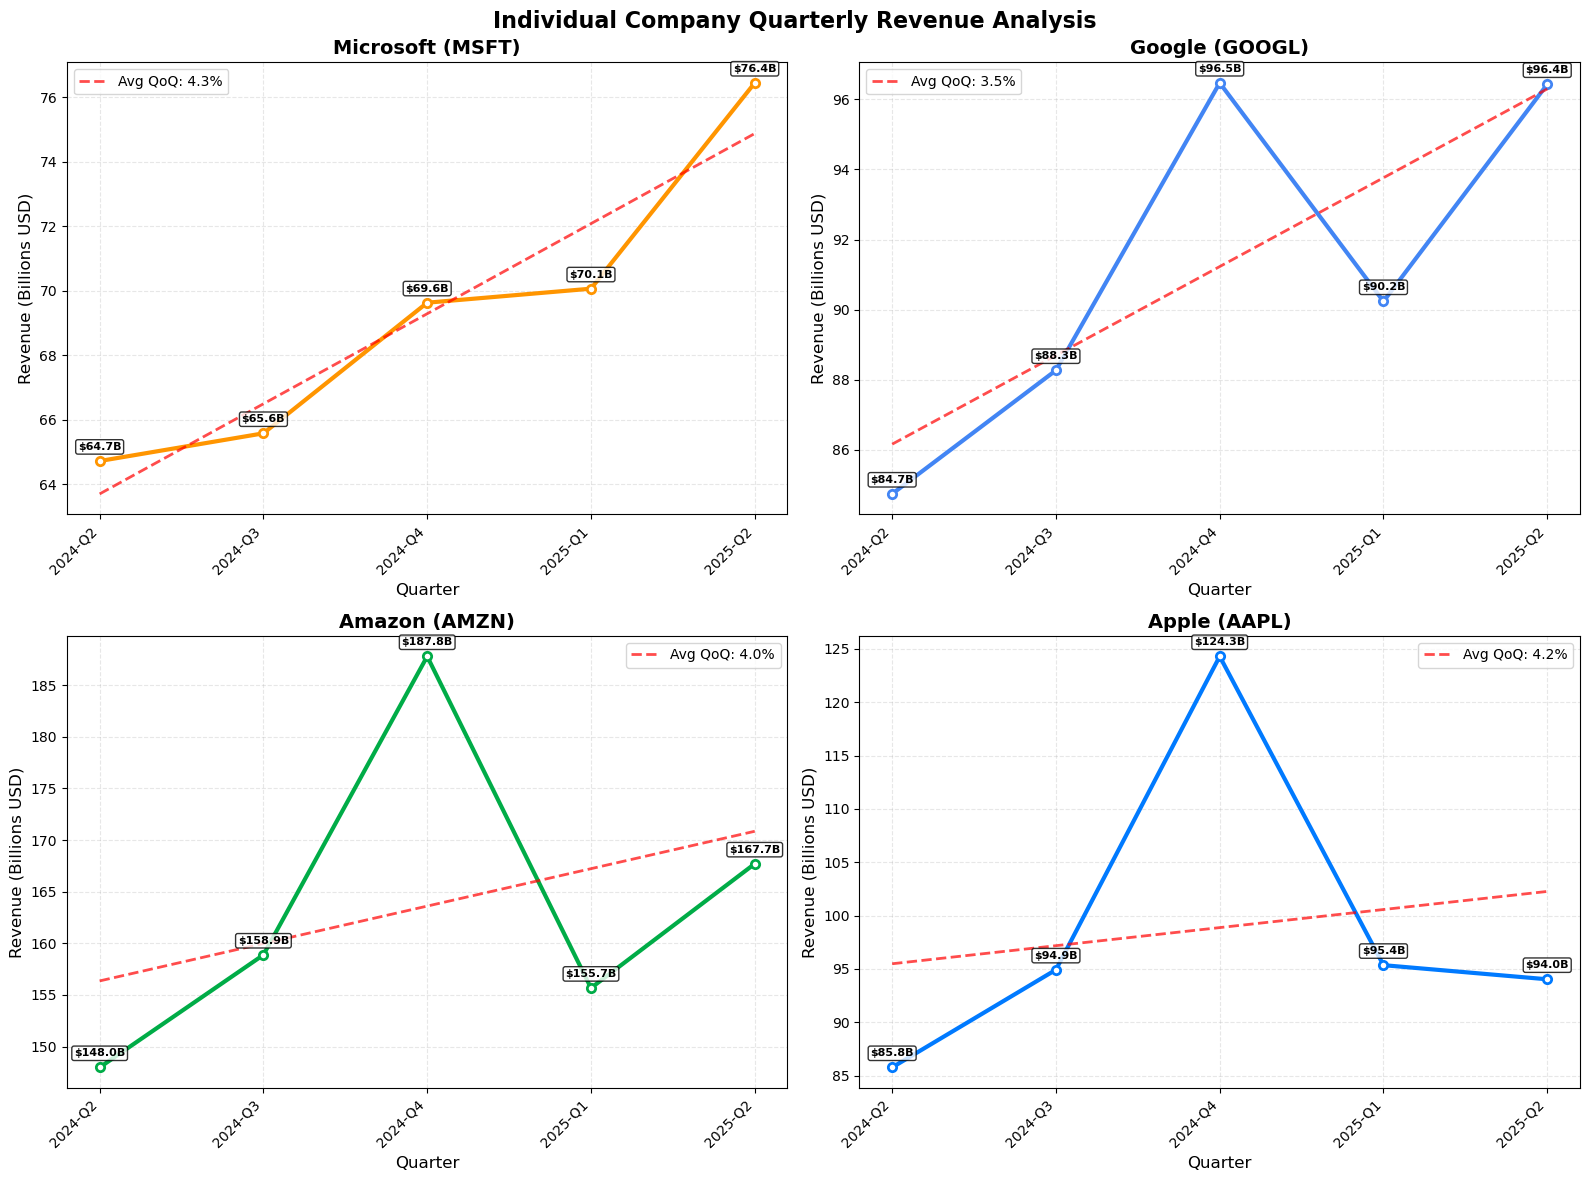


QUARTERLY GROWTH ANALYSIS

Microsoft Corporation (MSFT) - Quarter-over-Quarter Growth:
------------------------------------------------------------
2024-Q3: +1.3%
2024-Q4: +6.2%
2025-Q1: +0.6%
2025-Q2: +9.1%
Average QoQ Growth: +4.3%

Alphabet Inc. (GOOGL) - Quarter-over-Quarter Growth:
------------------------------------------------------------
2024-Q3: +4.2%
2024-Q4: +9.3%
2025-Q1: -6.5%
2025-Q2: +6.9%
Average QoQ Growth: +3.5%

Amazon.com, Inc. (AMZN) - Quarter-over-Quarter Growth:
------------------------------------------------------------
2024-Q3: +7.4%
2024-Q4: +18.2%
2025-Q1: -17.1%
2025-Q2: +7.7%
Average QoQ Growth: +4.0%

Apple Inc. (AAPL) - Quarter-over-Quarter Growth:
------------------------------------------------------------
2024-Q3: +10.7%
2024-Q4: +30.9%
2025-Q1: -23.3%
2025-Q2: -1.4%
Average QoQ Growth: +4.2%

📊 Analysis completed for 4 companies


In [11]:
if __name__ == "__main__":
    main()

Based on the results, we can see that Microsoft is the "winner" of the analysis. It has the highest P-E ratio, profit margin, and average quarter-to-quarter growth over the last year. This is inline with our group's findings, as well as the separate AI analysis we did.